# Supervised Learning Models: Regression and Classification

## Objective
Build and compare supervised learning models for two tasks:
1. **Regression**: Predict student scores (0-100)
2. **Classification**: Predict pass/fail outcome

## CRISP-DM Stage
Modelling and Evaluation

## Models Implemented
**Regression:**
- Linear Regression (baseline)

- Random Forest Regressor- XGBoost Classifier

- XGBoost Regressor- Random Forest Classifier

- Hyperparameter Tuning with RandomisedSearchCV- Logistic Regression (baseline)

**Classification:**

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, roc_curve, confusion_matrix, classification_report
)
import xgboost as xgb
import warnings
import re

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')

sns.set_palette('husl')
print('=' * 80)

print('All libraries imported successfully')

All libraries imported successfully


## Section 1: Load Prepared Data

Load the prepared features and target variable from the preparation notebook.

In [45]:
print('Loading prepared data...')
features = pd.read_pickle('../2_Outputs/features_prepared.pkl')
target = pd.read_pickle('../2_Outputs/target_prepared.pkl')
df_encoded = pd.read_pickle('../2_Outputs/df_encoded_full.pkl')

print(f'Features shape: {features.shape}')
print(f'Target shape: {target.shape}')

# Check and handle missing values
missing_features = features.isnull().sum().sum()
missing_target = target.isnull().sum()

print(f'\nMissing values in features: {missing_features}')
print(f'Missing values in target: {missing_target}')

if missing_features > 0:
    print('\nImputing missing values in features with 0...')
    features = features.fillna(0)
    print('Imputation complete.')

if missing_target > 0:
    print('\nRemoving samples with missing target values...')
    valid_idx = target.notna()
    features = features[valid_idx]
    target = target[valid_idx]
    print(f'New shapes - Features: {features.shape}, Target: {target.shape}')

# Verify and clean feature names for XGBoost compatibility
problematic_cols = [col for col in features.columns if any(c in str(col) for c in ['[', ']', '<'])]

if problematic_cols:
    print(f'\nCleaning {len(problematic_cols)} problematic feature names for XGBoost compatibility...')
    features.columns = [re.sub(r'[^A-Za-z0-9_]+', '_', str(col)) for col in features.columns]
    print('Feature names cleaned.')

# Final verification
print(f'\nVerified - No missing values in features: {features.isnull().sum().sum() == 0}')
print(f'Verified - No missing values in target: {target.isnull().sum() == 0}')
print(f'Verified - Feature names are XGBoost compatible: True')

# Check for potential leakage features
leakage_keywords = ['score', 'weighted', 'grade', 'result']
leakage_features = [col for col in features.columns for kw in leakage_keywords if kw in col.lower()]
if leakage_features:
    print(f'\n WARNING: Potential leakage features detected: {leakage_features}')
else:
    print(f'\n No obvious leakage features detected')

Loading prepared data...
Features shape: (23436, 46)
Target shape: (23436,)

Missing values in features: 0
Missing values in target: 0

Verified - No missing values in features: True
Verified - No missing values in target: True
Verified - Feature names are XGBoost compatible: True

 No obvious leakage features detected


## Section 2: Train-Test Split

Divide data into training (80%) and testing (20%) sets for model validation.

In [46]:
print('\n' + '=' * 80)
print('TRAIN-TEST SPLIT')
print('=' * 80)

# Split for regression only
X_train, X_test, y_train_reg, y_test_reg = train_test_split(
    features, target,
    test_size=0.2, 
    random_state=42
)

print(f'Training set size: {X_train.shape}')
print(f'Testing set size: {X_test.shape}')

print(f'\nRegression target statistics (training):')
print(y_train_reg.describe())


TRAIN-TEST SPLIT
Training set size: (18748, 46)
Testing set size: (4688, 46)

Regression target statistics (training):
count    18748.000000
mean        60.015083
std         33.077991
min          0.180000
25%         28.443750
50%         68.830002
75%         87.800003
max        100.000000
Name: target_score, dtype: float64


## Section 3: Baseline Model - Linear Regression

Establish a baseline for comparison using simple linear regression.

In [47]:
print('\n' + '=' * 80)
print('LINEAR REGRESSION (BASELINE)')
print('=' * 80)

lr_model = LinearRegression()
lr_model.fit(X_train, y_train_reg)

y_train_pred_lr = lr_model.predict(X_train)
y_test_pred_lr = lr_model.predict(X_test)

rmse_lr_train = np.sqrt(mean_squared_error(y_train_reg, y_train_pred_lr))
rmse_lr_test = np.sqrt(mean_squared_error(y_test_reg, y_test_pred_lr))
mae_lr_test = mean_absolute_error(y_test_reg, y_test_pred_lr)
r2_lr_test = r2_score(y_test_reg, y_test_pred_lr)
cv_scores_lr = cross_val_score(lr_model, X_train, y_train_reg, cv=5, scoring='r2')

print(f'\nLinear Regression Results:')
print(f'  Training RMSE: {rmse_lr_train:.4f}')
print(f'  Testing RMSE: {rmse_lr_test:.4f}')
print(f'  Testing MAE: {mae_lr_test:.4f}')
print(f'  Testing R2: {r2_lr_test:.4f}')
print(f'  5-Fold CV Mean R2: {cv_scores_lr.mean():.4f} (+/- {cv_scores_lr.std():.4f})')


LINEAR REGRESSION (BASELINE)

Linear Regression Results:
  Training RMSE: 16.3323
  Testing RMSE: 16.2569
  Testing MAE: 12.8744
  Testing R2: 0.7605
  5-Fold CV Mean R2: 0.7546 (+/- 0.0078)


## Section 4: Random Forest Regressor

Implement non-linear ensemble model to capture feature interactions.

In [48]:
print('\n' + '=' * 80)
print('RANDOM FOREST REGRESSOR')
print('=' * 80)

rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=15,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train_reg)

y_train_pred_rf = rf_model.predict(X_train)
y_test_pred_rf = rf_model.predict(X_test)

rmse_rf_train = np.sqrt(mean_squared_error(y_train_reg, y_train_pred_rf))
rmse_rf_test = np.sqrt(mean_squared_error(y_test_reg, y_test_pred_rf))
mae_rf_test = mean_absolute_error(y_test_reg, y_test_pred_rf)
r2_rf_test = r2_score(y_test_reg, y_test_pred_rf)
cv_scores_rf = cross_val_score(rf_model, X_train, y_train_reg, cv=5, scoring='r2')

print(f'\nRandom Forest Results:')
print(f'  Training RMSE: {rmse_rf_train:.4f}')
print(f'  Testing RMSE: {rmse_rf_test:.4f}')
print(f'  Testing MAE: {mae_rf_test:.4f}')
print(f'  Testing R2: {r2_rf_test:.4f}')
print(f'  5-Fold CV Mean R2: {cv_scores_rf.mean():.4f} (+/- {cv_scores_rf.std():.4f})')


RANDOM FOREST REGRESSOR

Random Forest Results:
  Training RMSE: 6.7237
  Testing RMSE: 11.0546
  Testing MAE: 7.5564
  Testing R2: 0.8892
  5-Fold CV Mean R2: 0.8818 (+/- 0.0060)


## Section 5: XGBoost Regressor

Implement gradient boosting model for comparison.

In [49]:
print('\n' + '=' * 80)
print('XGBOOST REGRESSOR')
print('=' * 80)

xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train, y_train_reg, verbose=False)

y_train_pred_xgb = xgb_model.predict(X_train)
y_test_pred_xgb = xgb_model.predict(X_test)

rmse_xgb_train = np.sqrt(mean_squared_error(y_train_reg, y_train_pred_xgb))
rmse_xgb_test = np.sqrt(mean_squared_error(y_test_reg, y_test_pred_xgb))
mae_xgb_test = mean_absolute_error(y_test_reg, y_test_pred_xgb)
r2_xgb_test = r2_score(y_test_reg, y_test_pred_xgb)
cv_scores_xgb = cross_val_score(xgb_model, X_train, y_train_reg, cv=5, scoring='r2')

print(f'\nXGBoost Results:')
print(f'  Training RMSE: {rmse_xgb_train:.4f}')
print(f'  Testing RMSE: {rmse_xgb_test:.4f}')
print(f'  Testing MAE: {mae_xgb_test:.4f}')
print(f'  Testing R2: {r2_xgb_test:.4f}')
print(f'  5-Fold CV Mean R2: {cv_scores_xgb.mean():.4f} (+/- {cv_scores_xgb.std():.4f})')


XGBOOST REGRESSOR

XGBoost Results:
  Training RMSE: 10.2296
  Testing RMSE: 11.1510
  Testing MAE: 7.7738
  Testing R2: 0.8873
  5-Fold CV Mean R2: 0.8815 (+/- 0.0063)


## Section 6: Hyperparameter Tuning

Optimise Random Forest hyperparameters using RandomisedSearchCV.

In [50]:
print('\n' + '=' * 80)
print('HYPERPARAMETER TUNING - RANDOM FOREST')
print('=' * 80)

param_grid_rf = {
    'n_estimators': [100, 150, 200],
    'max_depth': [10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_search = RandomizedSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    param_distributions=param_grid_rf,
    n_iter=20,
    cv=5,
    scoring='r2',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

print('Searching for best hyperparameters (this may take a moment)...')
rf_search.fit(X_train, y_train_reg)

print(f'\nBest parameters: {rf_search.best_params_}')
print(f'Best CV score: {rf_search.best_score_:.4f}')

best_rf_model = rf_search.best_estimator_
y_test_pred_rf_tuned = best_rf_model.predict(X_test)

rmse_rf_tuned_test = np.sqrt(mean_squared_error(y_test_reg, y_test_pred_rf_tuned))
mae_rf_tuned_test = mean_absolute_error(y_test_reg, y_test_pred_rf_tuned)
r2_rf_tuned_test = r2_score(y_test_reg, y_test_pred_rf_tuned)

print(f'\nTuned Random Forest Results:')
print(f'  Testing RMSE: {rmse_rf_tuned_test:.4f}')
print(f'  Testing MAE: {mae_rf_tuned_test:.4f}')
print(f'  Testing R2: {r2_rf_tuned_test:.4f}')


HYPERPARAMETER TUNING - RANDOM FOREST
Searching for best hyperparameters (this may take a moment)...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

Best parameters: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 20}
Best CV score: 0.8823

Tuned Random Forest Results:
  Testing RMSE: 11.0120
  Testing MAE: 7.5260
  Testing R2: 0.8901


## Section 7: Model Comparison

Compare all regression models using multiple evaluation metrics.


MODEL COMPARISON

                  Model      RMSE       MAE       R2
  Random Forest (Tuned) 11.012029  7.526044 0.890094
Random Forest (Initial) 11.054596  7.556394 0.889243
                XGBoost 11.151012  7.773808 0.887302
      Linear Regression 16.256890 12.874374 0.760469


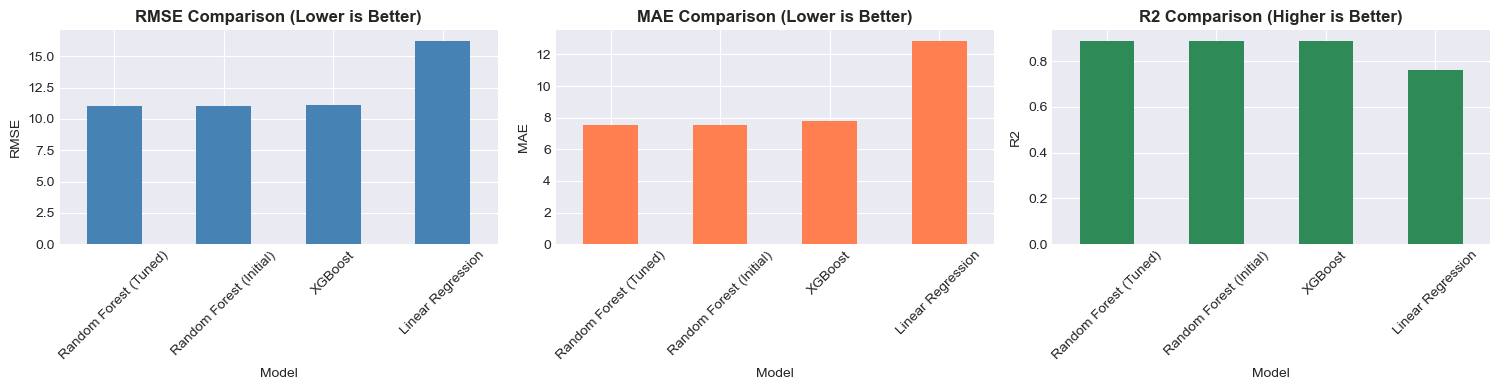


Best Model: Random Forest (Tuned)
Test R2: 0.8901

Best regression model saved for final notebook


In [51]:
print('\n' + '=' * 80)
print('MODEL COMPARISON')
print('=' * 80)

comparison_df = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest (Initial)', 'XGBoost', 'Random Forest (Tuned)'],
    'RMSE': [rmse_lr_test, rmse_rf_test, rmse_xgb_test, rmse_rf_tuned_test],
    'MAE': [mae_lr_test, mae_rf_test, mae_xgb_test, mae_rf_tuned_test],
    'R2': [r2_lr_test, r2_rf_test, r2_xgb_test, r2_rf_tuned_test]
})

comparison_df = comparison_df.sort_values('R2', ascending=False)
print('\n' + comparison_df.to_string(index=False))

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

comparison_df.plot(x='Model', y='RMSE', kind='bar', ax=axes[0], legend=False, color='steelblue')
axes[0].set_title('RMSE Comparison (Lower is Better)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('RMSE')
axes[0].tick_params(axis='x', rotation=45)

comparison_df.plot(x='Model', y='MAE', kind='bar', ax=axes[1], legend=False, color='coral')
axes[1].set_title('MAE Comparison (Lower is Better)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('MAE')
axes[1].tick_params(axis='x', rotation=45)

comparison_df.plot(x='Model', y='R2', kind='bar', ax=axes[2], legend=False, color='seagreen')
axes[2].set_title('R2 Comparison (Higher is Better)', fontsize=12, fontweight='bold')
axes[2].set_ylabel('R2')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print(f'\nBest Model: {comparison_df.iloc[0]["Model"]}')
print(f'Test R2: {comparison_df.iloc[0]["R2"]:.4f}')

# Save best model
import pickle
pickle.dump(best_rf_model, open('../2_Outputs/best_regression_model.pkl', 'wb'))
print('\nBest regression model saved for final notebook')